In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import utils
from torch.utils.data import DataLoader
import tqdm as tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from utils import load_csv, drop_cols, remove_strings, groupedAvg, subsample, normalize
from create_dataset import AnimalDataset, AnimalDatasetEmbedding
from generators import OneChannelUnetGenerator, MultiChannelUnetGenerator, SkipConnectionsMultiChannelUnetGenerator, EmbeddingUnetGenerator
from discriminators import OneChannelDiscriminator, MultiChannelDiscriminator 

/home/johann/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# config

ALLDATA = False # if False -> smaller dataset

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 512 
LEARNING_RATE = 1e-3  # 1e-5 was too small for 'LVtot_kalibriert' and 'LVtot' 
NUM_WORKERS = 10
NUM_EPOCHS = 100
LR_DECAY_AFTER_EPOCH = 200  
GENERATION_AFTER_EPOCH = NUM_EPOCHS # number of epochs after which the model generates a sample
SIG_A = "AoP"           # Drucksignal Hauptschlagader = Aortendruck
SIG_B = "VADcurrent"    # VAD Strom [A] – Pumpemstrom in Ampere
SIG_C = "VadQ"          # Fluss durch VAD (VAD = Ventrikular assistance device = Pumpe) = Pumpenfluss
SIG_D = "LVP"           # Ventrikeldruck links = Drucksignal der linken Herzkammer
TARGET = "LVtot_kalibriert"
feature_names = [SIG_A]
CHANNELS = len(feature_names)
WINDOW = 256
EMBEDDING = True
target = TARGET

SKIPCONNECTIONS = True

# Abailable Generators
# GENERATOR = OneChannelUnetGenerator or MultiChannelUnetGenerator or SkipConnectionsMultiChannelUnetGenerator

# Available Discminators
# DISCRIMINTOR = OneChannelDiscriminator or MultiChannelDiscriminator

load_from_epoch = 10  # select which Generator to load
gen_filename = 'Checkpoints/Gen_FeatureNames_{}_Target_[{}]_BatchSize_[{}]_LR_[{}]_Epoch_[{}].pth.tar'.format(feature_names, target, BATCH_SIZE, LEARNING_RATE, load_from_epoch)
disc_filename = 'Checkpoints/Disc_FeatureNames_{}_Target_[{}]_BatchSize_[{}]_LR_[{}]_Epoch_[{}].pth.tar'.format(feature_names, target, BATCH_SIZE, LEARNING_RATE, load_from_epoch)

CHECKPOINT_GEN = gen_filename
CHECKPOINT_DISC =  disc_filename
LOAD_MODEL = False
SAVE_MODEL = False
SAVE_EPOCH = 100


# Use cycle consistency loss
CYCLE = False
LAMBDA_CYCLE = 1.0
# Use supervised loss
SUPERVISED = True
LAMBDA_SUPERVISED = 1.0
# Use adversarial loss
ADVERSARIAL = False
LAMBDA_ADVERSARIAL = 1.0
# Use Identity loss
IDENTITY = True
LAMBDA_IDENTITY = 1.0


In [3]:
if ALLDATA == False:
    # load only a small part of the data and drop the unnecessary columns
    # paths of only a small part of the data
    path = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports_not_all_the_data/constant_speed_interventions/" 
    df = utils.load_csv(path)
    df = utils.drop_cols(df)
    df = df.dropna()

    # select only rows where 'Phasenzuordnung' is 1
    # df = df.loc[df['Phasenzuordnung'] == 1]

    print(df.shape)  

(8072873, 13)


In [4]:
if ALLDATA == True:
    # Load all the data and drop unnecessary columns
    # We load the data separately, to avoid a Runtime error

    # all the data
    path_1 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_1"  
    path_2 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_2"
    path_3 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_3"
    path_4 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_4"

    df_1 = utils.load_csv(path_1)
    df_1 = utils.drop_cols(df_1)

    df_2 = utils.load_csv(path_2)
    df_2 = utils.drop_cols(df_2)

    df_3 = utils.load_csv(path_3)
    df_3 = utils.drop_cols(df_3)

    df_4 = utils.load_csv(path_4)
    df_4 = utils.drop_cols(df_4)

    # concatenate the separate dataframes
    df = pd.concat([df_1, df_2, df_3, df_4], axis=0, ignore_index=True)
    df = df.dropna()

    print('Size of the whole dataset',df.shape)
    # select only rows where 'Phasenzuordnung' is 1
    # df = df.loc[df['Phasenzuordnung'] == 1]
    # print('Size of dataset with only the first phase',df.shape)

In [5]:
df = utils.remove_strings(df)
df = utils.subsample(df, 10)
df = utils.normalize(df)

print(df.shape)

(807287, 13)


In [6]:
# Which different intervention ids are there?
print('\nDifferent interventions: \n',df['intervention'].unique())

# How many different intervention ids are there?
print('\nNumber of different interventions: \n',len(df['intervention'].unique()))

# Which different phases are there?
print('\nDifferent phases (Phasenzuordnung): \n',df['Phasenzuordnung'].unique())

# hom many different phases are there?
print('\nNumber of different phases (Phasenzuordnung): \n',len(df['Phasenzuordnung'].unique()))

# hom many different animal ids are there?
print('\nDifferent animal IDs: \n',len(df['animal'].unique()))

# remove animals with less than 10 data points
df = df.groupby('animal').filter(lambda x: len(x) > 10)
print('\nDifferent animal IDs after removing those with less than 10 data points: \n',len(df['animal'].unique()))

# length of data per animal
#print(df.groupby('animal').size())

all_animals = df['animal'].unique()
# pick 2 random animals for test data
test_animals = df['animal'].sample(n=1, random_state=1).unique()

# remove test animals from train animals
train_animals =  [x for x in all_animals if x not in test_animals]

print('\nTest animals:', test_animals)
# test data
df_test = df[df['animal'].isin(test_animals)]

# train dataframe with only animals from train_animals
df_train = df[df['animal'].isin(train_animals)]
print('\nDifferent animal IDs after removing those that are in the test dataset: \n',len(df_train['animal'].unique()))


print('\nTrain data shape:', df_train.shape)
print('\nTest data shape:', df_test.shape)

#print('Unique animals in df_train: ',df_train['animal'].unique())
#print('Unique animals in df_test: ',df_test['animal'].unique())

# lengt of df_train
print('\nThe test dataset is {} percent of the whole data: '.format((len(df_test)/(len(df_train) + len(df_test))) * 100))


Different interventions: 
 [10.  6.  3.  1.  8.  2.  9.  5.  7.]

Number of different interventions: 
 9

Different phases (Phasenzuordnung): 
 [1.  1.4 2.  2.  2.  2.8 3.  3.  3.3 4.  4.7 5.  1.  1.4 2.4 3.7 4.1 2.2
 1.1 2.6 3.2 4.5 1.5 2.5 3.6 4.6 1.7 3.1 4.3 1.3 2.7 3.5 4.3 1.2 3.8 4.2
 3.9 4.1 2.6 1.1 2.3 1.4 1.8 2.2 1.4 1.6 2.1 2.4 3.  3.2 4.9 1.2 2.2 4.3
 1.4 1.9 2.9 4.2 3.8 4.9 1.6 2.8 3.4 1.3 2.4 1.8 4.7 3.3 4.1 2.4 3.1 4.2
 3.6 2.8 1.7 2.7 3.8 1.1 3.7 4.2 4.6 3.9 4.6 3.4 1.2 2.9 1.8 2.9 3.3 1.6
 2.1 3.6 4.7 4.4 4.9 3.1 2.7 3.8 1.9 3.7 4.7 2.7 4.1 2.2 2.6 1.9 3.2 4.3
 2.6 4.8 4.4 1.8 2.3 3.2 1.4 1.6 2.4 3.7 1.2 2.3]

Number of different phases (Phasenzuordnung): 
 120

Different animal IDs: 
 10

Different animal IDs after removing those with less than 10 data points: 
 6

Test animals: [16]

Different animal IDs after removing those that are in the test dataset: 
 5

Train data shape: (636231, 13)

Test data shape: (171038, 13)

The test dataset is 21.187237463596396 percent 

In [7]:
generator = EmbeddingUnetGenerator(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS = 1).to(DEVICE)
discriminator = MultiChannelDiscriminator(CHANNELS = 1).to(DEVICE)

opt_gen = torch.optim.AdamW(
    list(generator.parameters()) + list(generator.parameters()),
    lr=LEARNING_RATE,
)
opt_disc = torch.optim.AdamW(                                         
    list(discriminator.parameters()) + list(discriminator.parameters()), 
    lr=LEARNING_RATE, 
)

gen_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer = opt_gen,
                                                      total_iters = NUM_EPOCHS-LR_DECAY_AFTER_EPOCH, 
                                                      power = 2,
                                                    )
disc_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer = opt_disc,
                                                       total_iters = NUM_EPOCHS-LR_DECAY_AFTER_EPOCH, 
                                                       power = 2,
                                                    )

l1 = nn.L1Loss() 
mse = nn.MSELoss()

if LOAD_MODEL:
    utils.load_checkpoint(CHECKPOINT_GEN, generator, opt_gen, LEARNING_RATE)
    utils.load_checkpoint(CHECKPOINT_DISC, discriminator, opt_disc, LEARNING_RATE)

if EMBEDDING == False:
    # create datasets  
    train_dataset = AnimalDataset(df_train, feature_names, target_name = target, test = False, window_length = WINDOW)
    test_dataset = AnimalDataset(df_test, feature_names, target_name = target, test = True, window_length = WINDOW)
    gen_dataset = AnimalDataset(df_test, feature_names, target_name = target, test = False, window_length = WINDOW)

if EMBEDDING == True:
    train_dataset = AnimalDatasetEmbedding(df_train, feature_names, target_name = target, test = False, window_length = WINDOW)
    test_dataset = AnimalDatasetEmbedding(df_test, feature_names, target_name = target, test = True, window_length = WINDOW)
    gen_dataset = AnimalDatasetEmbedding(df_test, feature_names, target_name = target, test = False, window_length = WINDOW)

# Data loader
loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True,)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,)
gen_loader = DataLoader(gen_dataset, batch_size=1, shuffle=True, pin_memory=True,)

# run in float16
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

train_losses = {
            'Discrminator loss' : [],
            'Adversarial loss' : [],
            'Supervised loss' : [],
            'Identity loss' : [],
            'Total Generator loss' : [],
        }

test_losses = {
            'Discrminator loss' : [],
            'Adversarial loss' : [],
            'Supervised loss' : [],
            'Identity loss' : [],
            'Total Generator loss' : [],
            'L1 loss between real target signal and fake target signal' : [],
        }

/home/johann/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/optim/adamw.py:92: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(AdamW, self).__init__(params, defaults)


100%|█████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]

Generate fake signals


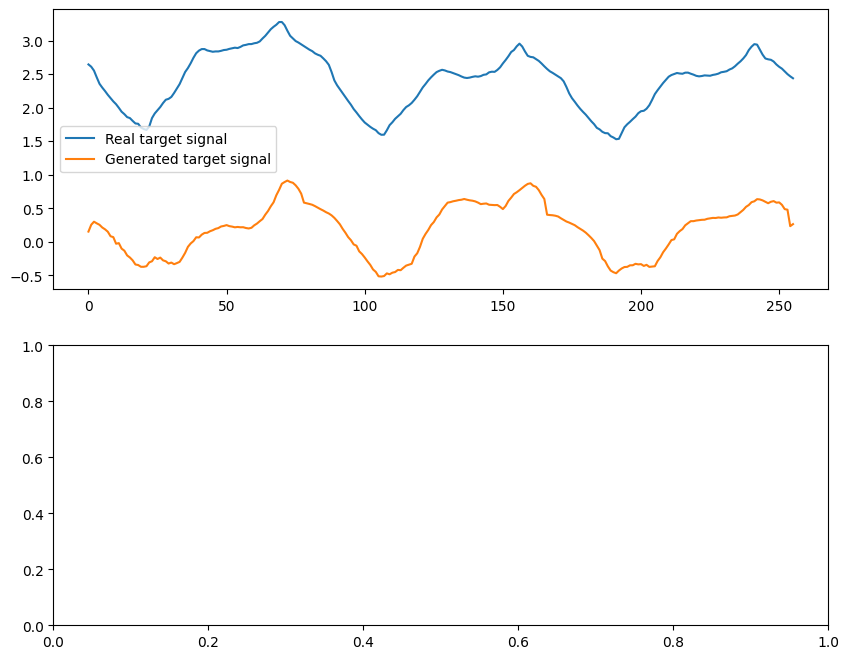

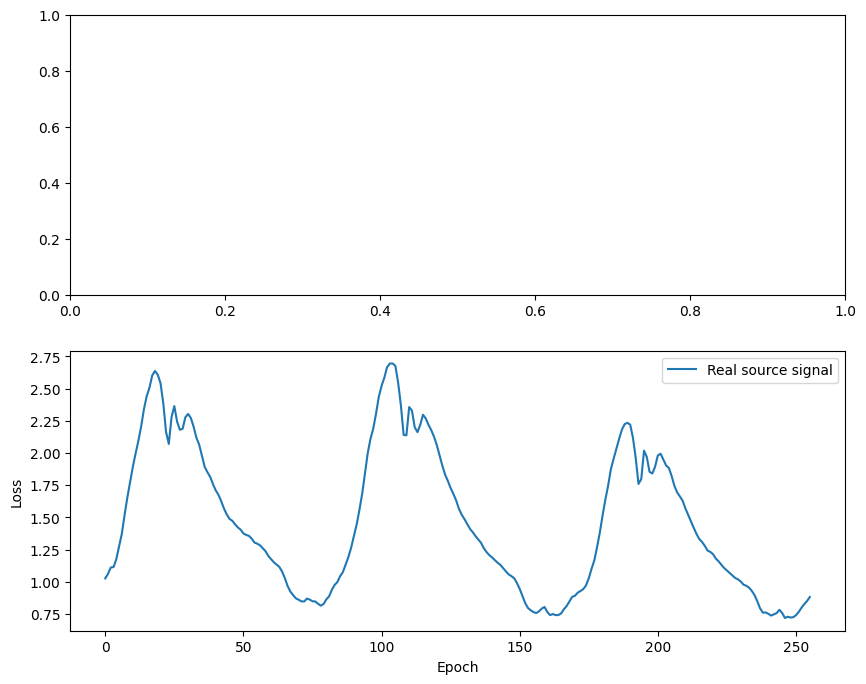

In [8]:
from tqdm.auto import tqdm

for epoch in tqdm(range(NUM_EPOCHS)):

    for source, target, intervention in loader:
        source = source.float()
        target = target.float()
        source = source.to(DEVICE)
        target = target.to(DEVICE)
        intervention = intervention.to(DEVICE)

        with torch.cuda.amp.autocast():
            fake_target = generator(source, intervention)
            d_target_real = discriminator(target)
            d_target_fake = discriminator(fake_target.detach())

            # disctiminator loss
            d_target_real_loss = mse(d_target_real, torch.ones_like(d_target_real))
            d_target_fake_loss = mse(d_target_fake, torch.zeros_like(d_target_fake))
            d_loss = d_target_fake_loss + d_target_real_loss

        opt_disc.zero_grad() 
        d_scaler.scale(d_loss).backward()  
        d_scaler.step(opt_disc)  
        d_scaler.update()

        with torch.cuda.amp.autocast():
            g_loss = 0
            if ADVERSARIAL: 
                d_target_fake = discriminator(fake_target) 
                g_target_loss = mse(d_target_fake, torch.ones_like(d_target_fake))
                g_loss += g_target_loss * LAMBDA_ADVERSARIAL

            if SUPERVISED:
                sup_target_loss = l1(target, fake_target)
                g_loss = sup_target_loss * LAMBDA_SUPERVISED

            if IDENTITY:
                id_target = generator(source, intervention)  # target not source
                id_target_loss = l1(target, id_target)
                g_loss += id_target_loss * LAMBDA_IDENTITY

        opt_gen.zero_grad()
        g_scaler.scale(g_loss).backward() 
        g_scaler.step(opt_gen) 
        g_scaler.update()

    train_losses['Discrminator loss'].append(d_loss.item())
#     train_losses['Adversarial loss'].append(g_target_loss.item())
    train_losses['Supervised loss'].append(sup_target_loss.item())
    train_losses['Identity loss'].append(id_target_loss.item())
    train_losses['Total Generator loss'].append(g_loss.item())

    if (epoch+1) % 10 == 0:

        with torch.no_grad():
            discriminator.eval()
            generator.eval()

            test_Discriminator_loss = 0
            test_Adversarial_loss = 0
            test_Supervised_loss = 0
            test_Identity_loss = 0
            test_L1_loss = 0
            # test_Generator_total = 0

            for source, target, intervention in test_loader:
                source = source.float()
                target = target.float()
                source = source.to(DEVICE)
                target = target.to(DEVICE)
                intervention = intervention.to(DEVICE)

                fake_target = generator(source, intervention)
                test_L1_loss = l1(target, fake_target)

                test_Generator_total = 0.
                if ADVERSARIAL:
                    test_Adversarial_loss = mse(discriminator(fake_target), torch.ones_like(discriminator(fake_target)))
                    test_Generator_total += test_Adversarial_loss * LAMBDA_ADVERSARIAL

                if SUPERVISED:
                    test_Supervised_loss = mse(target, fake_target)

                if IDENTITY:
                    id_target = generator(target, intervention)
                    test_Identity_loss = l1(target, id_target)

                    test_Generator_total += test_Identity_loss * LAMBDA_IDENTITY

                test_Discriminator_loss = mse(discriminator(target), torch.ones_like(discriminator(target)))

                test_losses['Discrminator loss'].append(d_loss.item())
#                 test_losses['Adversarial loss'].append(g_target_loss.item())
                test_losses['Supervised loss'].append(sup_target_loss.item())
                test_losses['Identity loss'].append(id_target_loss.item())
                test_losses['Total Generator loss'].append(g_loss.item())
                test_losses['L1 loss between real target signal and fake target signal'].append(test_L1_loss.item())

            #  ------------------------------------- #   
            #  ------- Generate fake signals ------- #
            #  ------------------------------------- #
            
            # Generate fake signals after the last epoch
            
            if (epoch+1) % GENERATION_AFTER_EPOCH == 0:
                print('Generate fake signals')
                # generate fake signals 10 times
                #utils.save_predictions(gen_loader, gen_B, gen_A, fake_A, fake_B, DEVICE, mse)
                idx =0
                for source, target, intervention in gen_loader:
                    if idx == 1:
                        break

                    source = source.float()
                    target = target.float()
                    source = source.to(DEVICE)
                    target = target.to(DEVICE)
                    intervention = intervention.to(DEVICE)

                    fake_target = generator(source, intervention)
                    # fake_source = generator(fake_target, intervention)

                    # plot generated signals and real signals
                    #reshape to 1D
                    fake_target = fake_target.reshape(-1)
                    # fake_source = fake_source.reshape(-1)
                    source = source.reshape(-1)
                    target = target.reshape(-1)
                    
                    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
                    ax[0].plot(target.cpu().numpy(), label= 'Real target signal')
                    ax[0].plot(fake_target.cpu().numpy(), label= 'Generated target signal')
                    ax[0].legend()

                    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
                    ax[1].plot(source.cpu().numpy(), label= 'Real source signal')
#                     ax[1].plot(fake_source.cpu().numpy(), label= 'Generated source signal from the generated target signal')
                    ax[1].set_xlabel('Epoch')
                    ax[1].set_ylabel('Loss')
                    ax[1].legend()


                    # plot generated signals and real signals
                    # plt.figure(figsize=(15, 5))
                    # plt.plot(sig_A.cpu().detach().numpy(), label= 'Real signal A')
                    # plt.plot(sig_B.cpu().detach().numpy(), label= 'Real signal B')
                    # plt.plot(fake_A.cpu().detach().numpy(), label= 'Generated signal A')
                    # plt.plot(fake_B.cpu().detach().numpy(), label= 'Generated signal B')
                    # plt.title('Generated signals vs real signals')
                    # plt.legend()

                    idx += 1


        discriminator.train()
        generator.train()

    # scheduler step if epoch > LR_DECAY_AFTER_EPOCH
    if (epoch+1) >= LR_DECAY_AFTER_EPOCH:
        disc_scheduler.step()
        gen_scheduler.step()


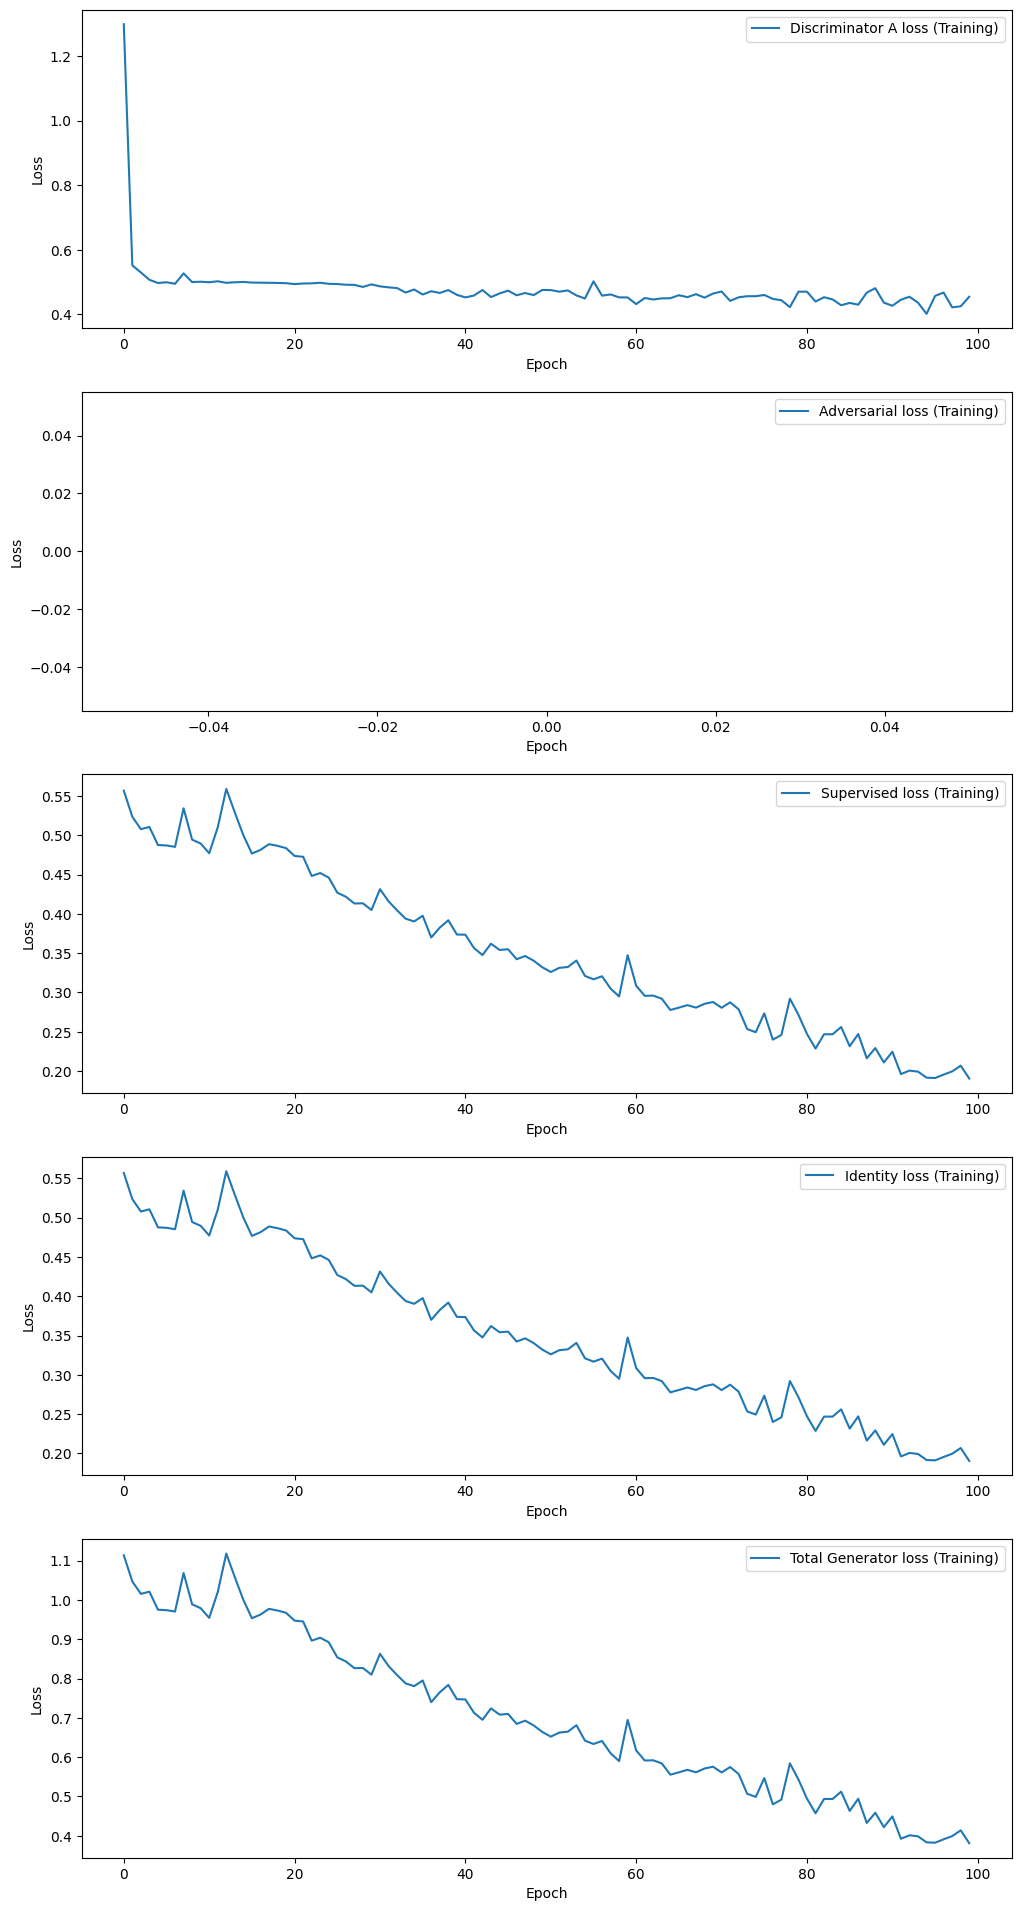

In [9]:
fig, ax = plt.subplots(5, 1, figsize=(12, 24))
ax[0].plot(train_losses['Discrminator loss'], label= 'Discriminator A loss (Training)')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_losses['Adversarial loss'], label= 'Adversarial loss (Training)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

ax[2].plot(train_losses['Supervised loss'], label= 'Supervised loss (Training)')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()

ax[3].plot(train_losses['Identity loss'], label= 'Identity loss (Training)')
ax[3].set_xlabel('Epoch')
ax[3].set_ylabel('Loss')
ax[3].legend()

ax[4].plot(train_losses['Total Generator loss'], label= 'Total Generator loss (Training)')
ax[4].set_xlabel('Epoch')
ax[4].set_ylabel('Loss')
ax[4].legend()

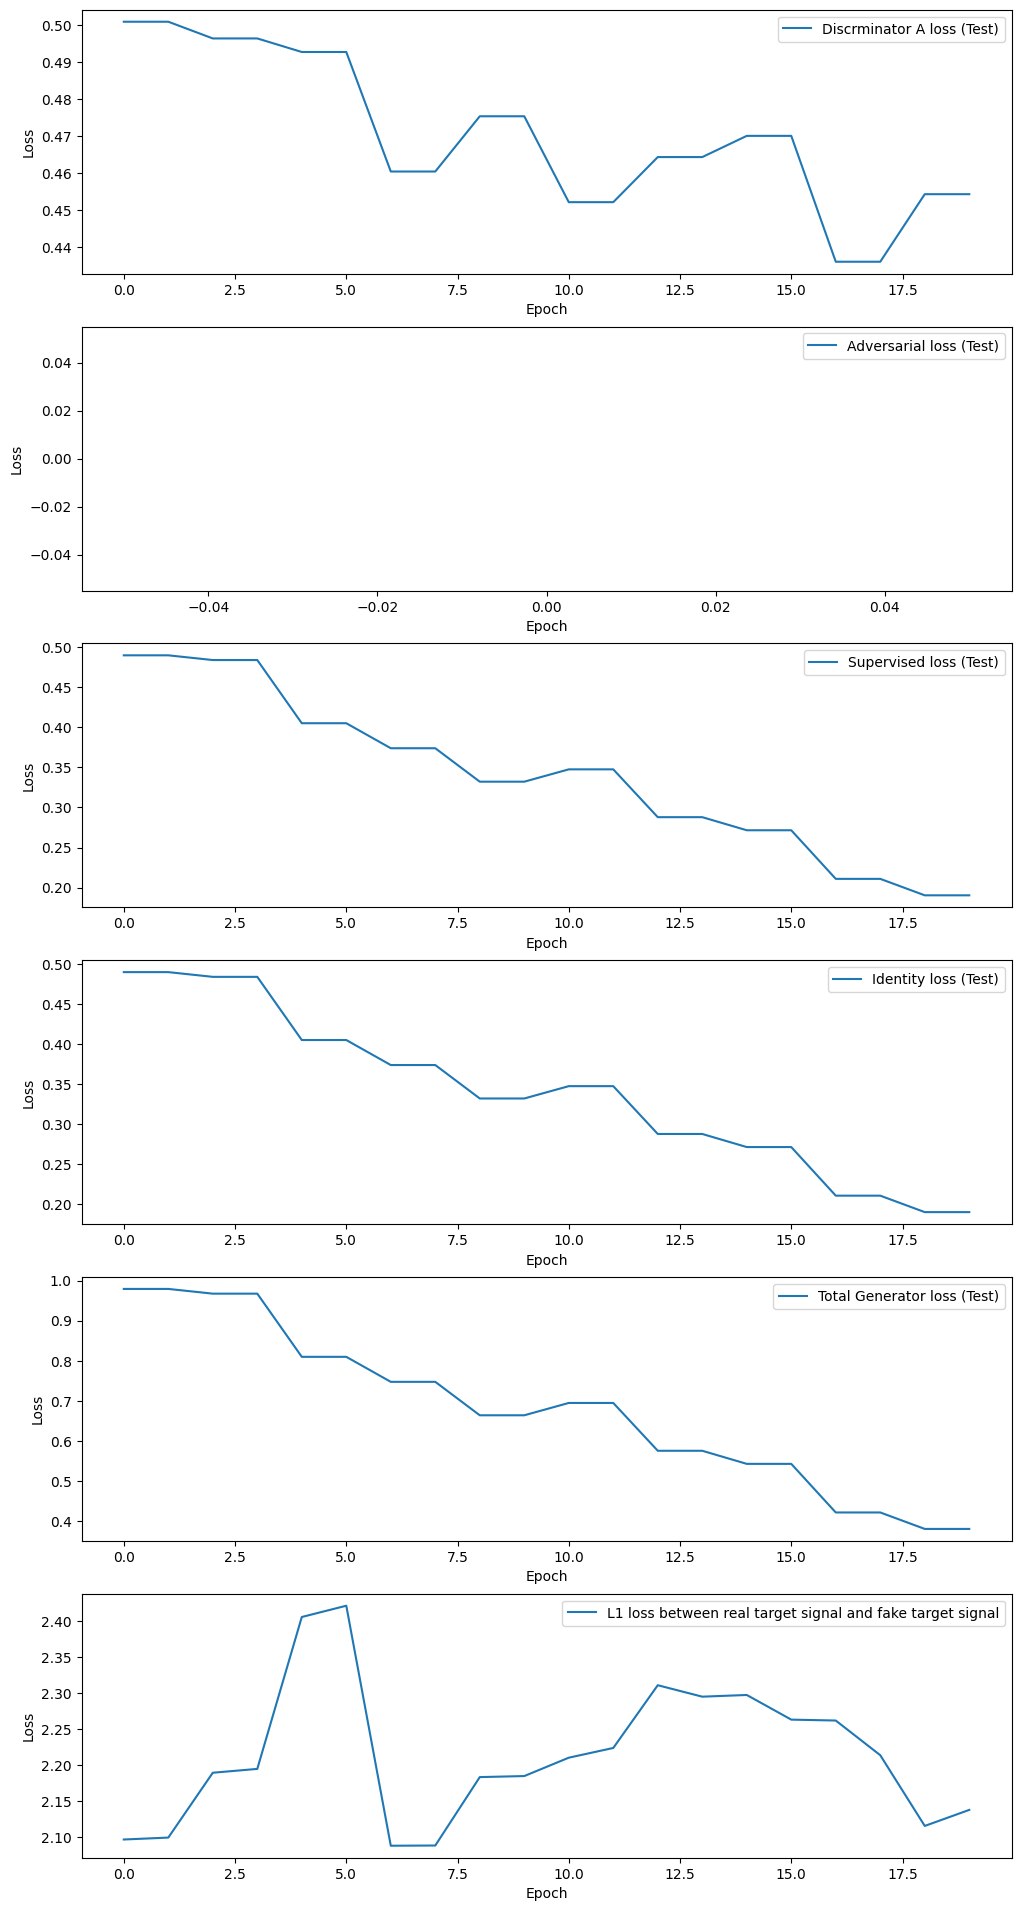

In [10]:
fig, ax = plt.subplots(6, 1, figsize=(12, 24))
ax[0].plot(test_losses['Discrminator loss'], label= 'Discrminator A loss (Test)')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(test_losses['Adversarial loss'], label= 'Adversarial loss (Test)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

ax[2].plot(test_losses['Supervised loss'], label= 'Supervised loss (Test)')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()

ax[3].plot(test_losses['Identity loss'], label= 'Identity loss (Test)')
ax[3].set_xlabel('Epoch')
ax[3].set_ylabel('Loss')
ax[3].legend()

ax[4].plot(test_losses['Total Generator loss'], label= 'Total Generator loss (Test)')
ax[4].set_xlabel('Epoch')
ax[4].set_ylabel('Loss')
ax[4].legend() 

ax[5].plot(test_losses['L1 loss between real target signal and fake target signal'], label= 'L1 loss between real target signal and fake target signal')
ax[5].set_xlabel('Epoch')
ax[5].set_ylabel('Loss')
ax[5].legend()